<a href="https://colab.research.google.com/github/hvmdvvn/Pytorch-Projects/blob/main/Bean_Leaf_Lesions_Classification_Image_Classification_Transfer_Learning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hvmfvvn
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.55GB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from torchvision.transforms import transforms
from torchvision import models

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [17]:
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]

train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [18]:
train_df["category"].unique()

array([0, 1, 2])

In [19]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [20]:
print(train_df["category"].value_counts())
print(val_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64
category
2    45
0    44
1    44
Name: count, dtype: int64


In [21]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [22]:
class CustomImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(df["category"]).to(device)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image_path = self.df.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(image_path)

    if self.transform:
      image =( self.transform(image)/255.0).to(device)

    return image, label

In [23]:
train_dataset = CustomImageDataset(df = train_df, transform=transform)
val_dataset = CustomImageDataset(df = val_df, transform=transform)

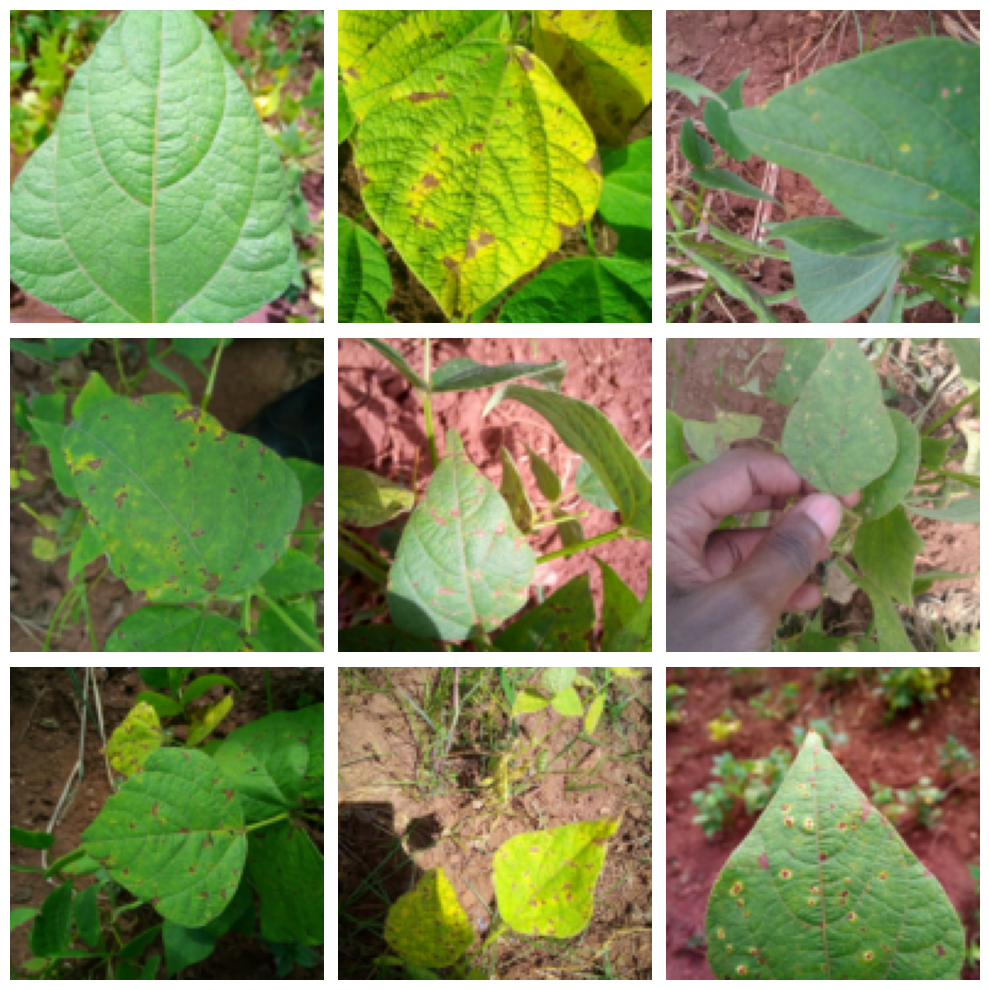

In [25]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols, figsize=(10,10))

for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0, len(train_dataset))][0].cpu()
    axarr[row, col].imshow((image*255.0).squeeze().permute(1, 2, 0))
    axarr[row, col].axis("off")

plt.tight_layout()
plt.show()

In [26]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [35]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
googlenet_model = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 102MB/s] 


In [28]:
for param in googlenet_model.parameters():
  param.requires_grad = True

In [30]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [31]:
num_classes = len(train_df["category"].unique())
num_classes

3

In [32]:
googlenet_model.fc = nn.Linear(in_features=1024, out_features=num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [33]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [36]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for data in train_loader:
    inputs, labels = data

    optimizer.zero_grad()

    prediction = googlenet_model(inputs)

    batch_loss = loss_fun(prediction, labels)
    total_loss_train += batch_loss.item()

    batch_loss.backward()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_train += acc

    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))

  print(f'''
  Epoch No. {epoch+1},
  Train Loss: {round(total_loss_train/1000, 4)},
  Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}%
        ''')
  print('='*25)


  Epoch No. 1,
  Train Loss: 0.2487,
  Train Accuracy: 53.4816%
        

  Epoch No. 2,
  Train Loss: 0.2248,
  Train Accuracy: 60.9284%
        

  Epoch No. 3,
  Train Loss: 0.1984,
  Train Accuracy: 67.3114%
        

  Epoch No. 4,
  Train Loss: 0.1848,
  Train Accuracy: 69.6325%
        

  Epoch No. 5,
  Train Loss: 0.1864,
  Train Accuracy: 70.4062%
        

  Epoch No. 6,
  Train Loss: 0.1717,
  Train Accuracy: 72.5338%
        

  Epoch No. 7,
  Train Loss: 0.1609,
  Train Accuracy: 75.2418%
        

  Epoch No. 8,
  Train Loss: 0.1469,
  Train Accuracy: 76.9826%
        

  Epoch No. 9,
  Train Loss: 0.1368,
  Train Accuracy: 78.6267%
        

  Epoch No. 10,
  Train Loss: 0.13,
  Train Accuracy: 80.9478%
        

  Epoch No. 11,
  Train Loss: 0.1128,
  Train Accuracy: 82.6886%
        

  Epoch No. 12,
  Train Loss: 0.1206,
  Train Accuracy: 82.882%
        

  Epoch No. 13,
  Train Loss: 0.1227,
  Train Accuracy: 82.882%
        

  Epoch No. 14,
  Train Loss: 0.0953,

In [37]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in val_loader:
    inputs, labels = data

    prediction = googlenet_model(inputs).squeeze(1)

    batch_loss = loss_fun(prediction, labels)
    total_loss_test += batch_loss.item()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc


print(f"Accuracy: {round(total_acc_test/val_dataset.__len__() * 100, 4)} and Loss: {round(total_loss_test/1000, 4)}")

Accuracy: 83.4586 and Loss: 0.0159


## Transfer Learning (Only Last Layer)

In [40]:
googlenet_model = models.googlenet(weights='DEFAULT')

for param in googlenet_model.parameters():
  param.requires_grad = False

googlenet_model.fc = nn.Linear(in_features=1024, out_features=num_classes)
googlenet_model.fc.requires_grad = True

googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [41]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for data in train_loader:
    inputs, labels = data

    optimizer.zero_grad()

    prediction = googlenet_model(inputs)

    batch_loss = loss_fun(prediction, labels)
    total_loss_train += batch_loss.item()

    batch_loss.backward()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_train += acc

    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__() * 100, 4))

  print(f'''
  Epoch No. {epoch+1},
  Train Loss: {round(total_loss_train/1000, 4)},
  Train Accuracy: {round(total_acc_train/train_dataset.__len__() * 100, 4)}%
        ''')
  print('='*25)


  Epoch No. 1,
  Train Loss: 0.2659,
  Train Accuracy: 48.4526%
        

  Epoch No. 2,
  Train Loss: 0.2438,
  Train Accuracy: 56.8665%
        

  Epoch No. 3,
  Train Loss: 0.2388,
  Train Accuracy: 56.383%
        

  Epoch No. 4,
  Train Loss: 0.2332,
  Train Accuracy: 57.5435%
        

  Epoch No. 5,
  Train Loss: 0.2208,
  Train Accuracy: 61.6054%
        

  Epoch No. 6,
  Train Loss: 0.2228,
  Train Accuracy: 61.7988%
        

  Epoch No. 7,
  Train Loss: 0.2184,
  Train Accuracy: 61.1219%
        

  Epoch No. 8,
  Train Loss: 0.2157,
  Train Accuracy: 61.7021%
        

  Epoch No. 9,
  Train Loss: 0.2132,
  Train Accuracy: 63.3462%
        

  Epoch No. 10,
  Train Loss: 0.2135,
  Train Accuracy: 62.2824%
        

  Epoch No. 11,
  Train Loss: 0.2238,
  Train Accuracy: 62.089%
        

  Epoch No. 12,
  Train Loss: 0.2186,
  Train Accuracy: 60.8317%
        

  Epoch No. 13,
  Train Loss: 0.2034,
  Train Accuracy: 66.3443%
        

  Epoch No. 14,
  Train Loss: 0.225

In [42]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in val_loader:
    inputs, labels = data

    prediction = googlenet_model(inputs).squeeze(1)

    batch_loss = loss_fun(prediction, labels)
    total_loss_test += batch_loss.item()

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    total_acc_test += acc


print(f"Accuracy: {round(total_acc_test/val_dataset.__len__() * 100, 4)} and Loss: {round(total_loss_test/1000, 4)}")

Accuracy: 64.6617 and Loss: 0.0296
